In [12]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random
import matplotlib.pyplot as plt
from psychopy import visual, event, core
from scipy.ndimage import gaussian_filter

In [14]:
def ShowImage(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off') 
    plt.show()


def PiImage(ori = None, diff = 20):
    size, fixed_length, diff, leg_width, bar_height = 128, 80, diff, 2, 2
    Pi = np.zeros((size, size)) 

    spacing = size // 3
    left_x = spacing
    right_x = size - spacing - leg_width

    bar_y = int(size * 1/4) 

    if ori == None:
        right_len = fixed_length + diff * 3
        left_len = fixed_length + diff * 3

        Pi[bar_y:bar_y + left_len // 2, left_x:left_x + leg_width] = 1
        Pi[bar_y:bar_y + right_len // 2, right_x:right_x + leg_width] = 1

        bar_y1 = bar_y - bar_height // 2
        bar_y2 = bar_y + bar_height // 2
        Pi[bar_y1:bar_y2, left_x + leg_width:right_x] = 1

        return Pi.astype(np.float32)
        
    elif ori == 'right':
        right_len = fixed_length + diff
        left_len = fixed_length
    elif ori == 'left' :
        right_len = fixed_length 
        left_len = fixed_length + diff

    Pi[bar_y:bar_y + left_len // 2, left_x:left_x + leg_width] = 0.5
    Pi[bar_y:bar_y + right_len // 2, right_x:right_x + leg_width] = 0.5

    bar_y1 = bar_y - bar_height // 2
    bar_y2 = bar_y + bar_height // 2
    Pi[bar_y1:bar_y2, left_x + leg_width:right_x] = 0.5
            
    return Pi.astype(np.float32)

def AddNoise(sigma = 3):
    blur = gaussian_filter(PiImage(ori = None), sigma=sigma)
    blur = (blur - blur.min()) / (blur.max() - blur.min())
    return blur


def PiStimulus(ori, alpha = 0.01, diff = 20, show = False):
    noise = AddNoise()
    Pi = PiImage(ori = ori, diff = diff)
    Pi = Pi * alpha + noise * (1 - alpha)

    if show == True:
        ShowImage(Pi)
    return Pi

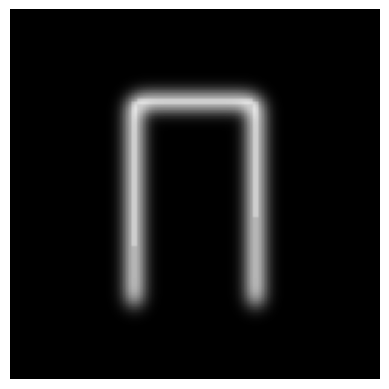

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
PiStimulus(ori = 'left', alpha = 0.2, show = True)

Experiment aborted during practice.
Experiment aborted by user.
190.2838 	WARNING 	Monitor specification not found. Creating a temporary one...
190.3433 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [3440, 1440]. Using actual size


ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

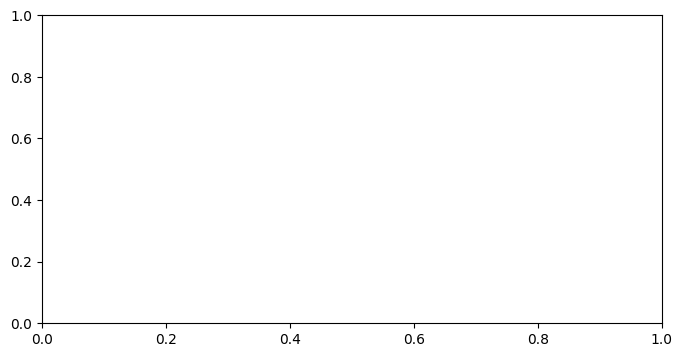

In [18]:
def Norm(image):
    return 2 * image - 1

# Visual Setup
win = visual.Window(size=(1920, 1080), color=-1, units="pix", fullscr=True)
stim = visual.ImageStim(win, size=(512, 512), units="pix")

# Parameters
oris = ['left', 'right']
alpha = 0.2
alpha_practice = [0.15, 0.2, 0.25]
step_size = 0.01
n_trials = 50
n_practices = 10
correct_counter = 0
data = []

# Welcome Screen
text = visual.TextStim(win, text="Welcome to the experiment! Press SPACE to begin the instruction", color=1.0, height=24)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])

# Instruction Screen
text = visual.TextStim(win, text="In this experiment, you will see a Pi-shape target embedded in blur. The two legs of the Pi-shape stimulus has different length.\
                                        The below one has a longer left leg.\
                                        \n\n In this experiment, your task is to identify which leg is longer after the Pi-shape target is briefly presented at the center of the screen\
                                        \n\n If you think the left leg is longer, press 'x'. If you think the right leg is longer, press 'm'.\
                                        \n\n Press SPACE to continue", color=1.0, height=24, pos = (0, 200))
text.draw()
image = visual.ImageStim(image = np.flipud(Norm(PiStimulus(ori = 'left', alpha = 0.25))), win = win, size=(512, 512), pos = (0, -200), units="pix")
image.draw()
win.flip()
event.waitKeys(keyList=['space'])

# Practice trail screen
text = visual.TextStim(win, text="We will begin with several practice trials, feedback on correctness will be provided after each trial.\
                                \n\n If you think the left leg is longer, press 'x'. If you think the right leg is longer, press 'm'.\
                                \n\n Press SPACE to start the practice trials. ", color=1.0, height=24)
text.draw()
win.flip()
event.waitKeys(keyList=['space'])
for trial in range(n_practices):
    if 'escape' in event.getKeys():
        print("Experiment aborted during practice.")
        break

    # Fixation
    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)

    # Stimulus
    ori, practice_alpha = random.choice(oris), random.choice(alpha_practice)
    stim.image = np.flipud(Norm(PiStimulus(ori=ori, alpha=practice_alpha)))
    stim.draw()
    win.flip()
    core.wait(0.5)
    win.flip()

    wait = visual.TextStim(win, text="Choose the orientation", color=1.0, height=48)
    wait.draw()
    win.flip()
    keys = event.waitKeys(keyList=['x', 'm', 'escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break
    win.flip()

    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori

    # Feedback 
    feedback_text = "Right" if correct else "Wrong"
    feedback_color = 'green' if correct else 'red'
    
    feedback = visual.TextStim(win, text=feedback_text, color=feedback_color, height=36)
    feedback.draw()
    win.flip()
    core.wait(0.5)
    win.flip()
    core.wait(0.5)


# --- Main Staircase Block ---
text = visual.TextStim(win, text="Excellent! Here comes the main experiment. This time the task is more difficult, please pay attention\
                                \n\n If you think the left leg is longer, press 'x'. If you think the right leg is longer, press 'm'.\
                                \n\n Press SPACE to start the main experiment. ", color=1.0, height=24)

text.draw()
win.flip()
event.waitKeys(keyList=['space'])

for trial in range(n_trials):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)

    ori = random.choice(oris)
    stim.image = np.flipud(Norm(PiStimulus(ori=ori, alpha=alpha)))
    stim.draw()
    win.flip()
    core.wait(0.5)
    win.flip()

    wait = visual.TextStim(win, text="Choose the leg", color=1.0, height=48)
    wait.draw()
    win.flip()
    keys = event.waitKeys(keyList=['x', 'm', 'escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break
    win.flip()


    response = 'left' if keys[0] == 'x' else 'right'
    correct = response == ori

    data.append({"trial": trial + 1, "orientation": ori, "response": response,
                 "correct": correct, "alphas": alpha})

    if correct:
        correct_counter += 1
        if correct_counter == 2:
            alpha = max(0, alpha - step_size)
            correct_counter = 0
    else:
        alpha = alpha + step_size
        correct_counter = 0
    core.wait(0.5)


# Cleanup 
win.close()

# ---------- Plot ----------
alphas = [d["alphas"] for d in data]
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_trials + 1), alphas, marker='o')
plt.xlabel("Trial")
plt.ylabel("Alphas")
plt.title("2-Down-1-Up Staircase")
plt.grid(True)
plt.show()

# Optional: save data
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("Results.csv", index=False)